#1) 시계열 분석
* 시간에 따라 관측된 데이터를 분석하여 미래의 값을 예측하거나 데이터의 패턴을 이해하는 것


In [2]:
import pandas as pd
df = pd.read_csv('./temperature_data.csv')
df

,Date,Temperature
0,2023-01-01,-1.161276
1,2023-01-02,-0.910024
2,2023-01-03,2.839168
3,2023-01-04,3.788326
4,2023-01-05,1.115325
...,...,...
295,2023-10-23,9.410780
296,2023-10-24,11.203737
297,2023-10-25,8.912885
298,2023-10-26,10.205989


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         300 non-null    object 
 1   Temperature  300 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.8+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         300 non-null    datetime64[ns]
 1   Temperature  300 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.8 KB


In [5]:
df.set_index('Date',inplace =True)
df

,Temperature
Date,
2023-01-01,-1.161276
2023-01-02,-0.910024
2023-01-03,2.839168
2023-01-04,3.788326
2023-01-05,1.115325
...,...
2023-10-23,9.410780
2023-10-24,11.203737
2023-10-25,8.912885


# 2)시계열 분해
시계열 데이터를 구성하는 주요 요소들을 분리하여 시계열 데이터를 살펴보는 방법

## 주요 구성요소
* 추세(Trend) : 데이터의 장기적인 방향성
* 계절성(Seasonality) : 일정 주기로 반복되는 패턴
* 불규칙성(잔차) : 추세 및 계절성을 제거 후 남는 불규칙 변동

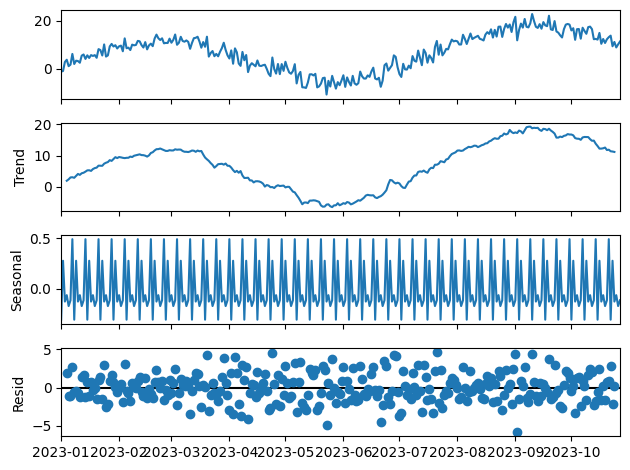

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(df, model = 'additive')
result.plot()
plt.show()


# 3) 시계열 예측 모델 생성
* 데이터가 정상성을 만족해야 함
  * 차분, 로그변환등이 있음

## 시계열 예측 모형
* ARIMA : AR(자기회귀) 모델과 MA(이동평균) 모델의 결합에 더해, 데이터의 비정상성을 제거하기 위한 차분을 포함하는 모델
* SARIMA : ARIMA 모델의 확장하여 계절성 또한 포함하는 모델

In [10]:
# 귀무가설 : 시계열 데이터가 정상성을 가지지 않는다
# 대립가설 : 시계열 데이터가 정상성을 가진다.
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df['Temperature'])
print('adf 통계량 : ',adf[0])
print('p-value : ',adf[1])

adf 통계량 :  -1.4891316512616641
p-value :  0.5388807410140046


In [11]:
# 정상성 만족을 위한 차분
diff = df.diff(1)
diff.dropna(inplace = True)


In [13]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(diff['Temperature'])
print('adf 통계량 : ',adf[0])
print('p-value : ',adf[1])

adf 통계량 :  -11.59980365440354
p-value :  2.665741836029786e-21


In [14]:
# 트레인 데이터 7, 테스트 데이터 3
cut = int(len(df) * 0.7)
train_data = df[:cut]
test_data = df[cut:]

In [15]:
train_data

,Temperature
Date,
2023-01-01,-1.161276
2023-01-02,-0.910024
2023-01-03,2.839168
2023-01-04,3.788326
2023-01-05,1.115325
...,...
2023-07-25,6.720818
2023-07-26,8.305848
2023-07-27,8.102038


In [17]:
from sklearn.model_selection import train_test_split
train_sk, test_sk = train_test_split(df, train_size = 0.7, shuffle = False)
train_sk

,Temperature
Date,
2023-01-01,-1.161276
2023-01-02,-0.910024
2023-01-03,2.839168
2023-01-04,3.788326
2023-01-05,1.115325
...,...
2023-07-25,6.720818
2023-07-26,8.305848
2023-07-27,8.102038


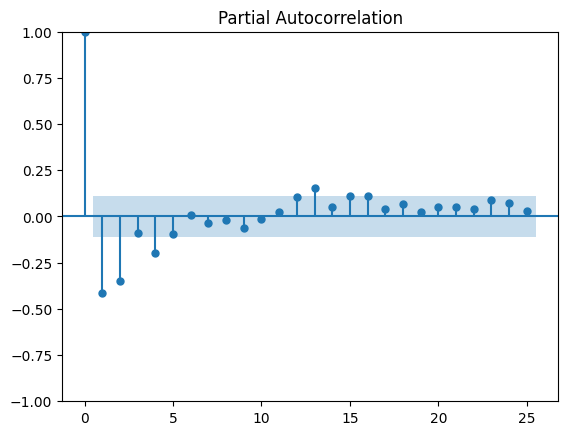

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
plot_pacf(diff)
plt.show()

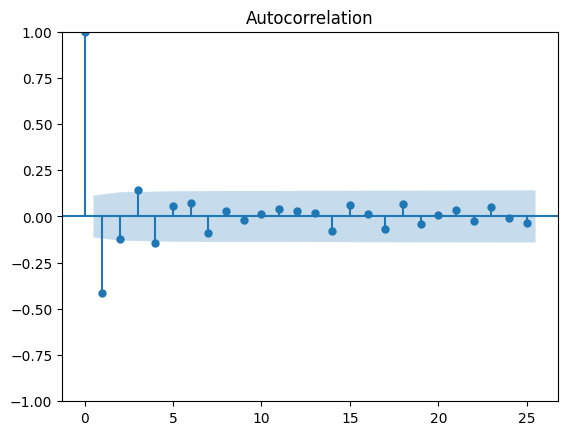

In [19]:
plot_acf(diff)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


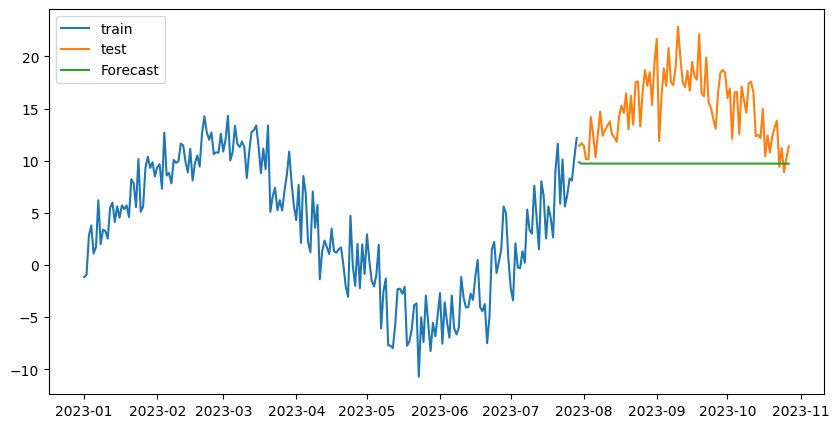

In [20]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

p,d,q = 1,1,1
model=ARIMA(train_data, order= (p,d,q))
model_fit = model.fit()

# 예측
forecast = model_fit.forecast(steps = len(test_data))

plt.figure(figsize = (10,5))
plt.plot(train_data, label = 'train')
plt.plot(test_data, label = 'test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import r2_score
r2_score(test_data.values, forecast)

-2.998711837172147

In [22]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(forecast, test_data.values)

In [23]:
mse

39.365882163733104

In [24]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00


In [26]:
import pmdarima as pm
model = pm.auto_arima(train_data, seasonal = True, m = 12, information_criterion = 'aic', stepwise = True, trace = True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=977.833, Time=2.34 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1043.789, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1008.099, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=972.885, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1041.889, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=976.604, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=974.675, Time=1.30 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=974.571, Time=1.88 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=973.580, Time=0.41 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=6.77 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1044.773, Time=0.14 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=974.653, Time=0.32 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=974.591, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1007.632, Time=0.16 sec
 ARIMA(1,1,2)(0,0,1)[12] interce